# 保持器のインデックスから新しいVTKファイルの作成

In [17]:
import numpy as np
import xml.etree.ElementTree as ET

def read_sections_from_xml(file_path, section_name, exclude_key='never_used_key'):
    tree = ET.parse(file_path)

    sections = []

    for t in tree.iter():
        if t.tag != section_name:
            continue
        for k in t.iter():
            if exclude_key in k.tag:
                break
            sections.extend(k.text.strip().split())

    return np.array(sections, dtype=int)


In [45]:
edge_index = read_sections_from_xml('../data/face_and_edge_index.xml', 'edge')
face_index = read_sections_from_xml('../data/face_and_edge_index.xml', 'face', 'periodic')

edge_index.shape, face_index.shape

((631,), (6103,))

In [46]:
all_index = np.concatenate([edge_index, face_index])
all_index = np.unique(all_index)
all_index.shape

(6670,)

## VTKファイルから該当インデックスを含む面を取得

In [47]:
import pyvista as pv
from matplotlib import pyplot as plt

# full_mesh = pv.read('../data/Tetra.vtu')
full_mesh = pv.read('../data/Tetra_smoothed.vtu')
full_points = np.array(full_mesh.points.tolist()) 
full_points.shape


(66723, 3)

In [48]:
tetras = full_mesh.cells.reshape(-1, 5)[:,1:]
tetras[:5], tetras.shape

(array([[ 1,  3,  0,  2],
        [ 4,  2,  3,  5],
        [ 8,  5,  7,  6],
        [ 5,  8,  9, 10],
        [ 7,  5,  8,  9]]),
 (295008, 4))

In [49]:
from collections import Counter
counter = Counter(tuple(t) for t in tetras)
duplicates = {t: count for t, count in counter.items() if count > 1}

print(duplicates)


{}


In [50]:
tetra_count = np.isin(tetras, all_index)
tetra_count, tetra_count.shape

(array([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]),
 (295008, 4))

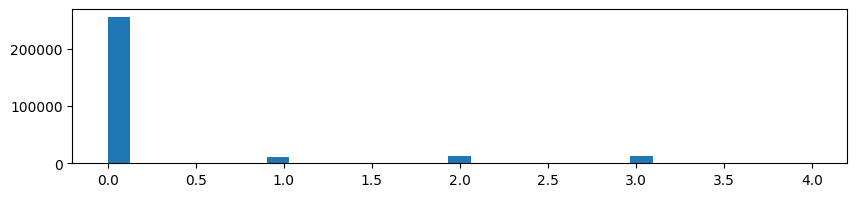

In [51]:
plt.figure(figsize=(10, 2))
plt.hist(tetra_count.sum(axis=1), bins=31)
plt.show()


In [52]:
is_face = tetra_count.sum(axis=1) == 3
surface_tetras = tetras[is_face]

triangles_count = np.isin(surface_tetras, all_index)
surface_triangles = surface_tetras[triangles_count].reshape(-1, 3)

unique_triangles = np.unique(surface_triangles, axis=0)
unique_triangles, unique_triangles.shape

(array([[ 1762,  1891,  2199],
        [ 1762,  2199,  2814],
        [ 1762,  2204,  2814],
        ...,
        [66420, 66267, 66338],
        [66420, 66338, 66404],
        [66420, 66404, 66414]]),
 (13298, 3))

In [53]:
points_array = full_points[all_index]
index_array = np.arange(all_index.shape[0])
triangles_array = np.array([np.where(all_index == t)[0][0] for t in unique_triangles.flatten()]).reshape(-1, 3)

points_array.shape, index_array.shape, triangles_array.shape

((6670, 3), (6670,), (13298, 3))

In [54]:
triangles_array

array([[   0,    3,    8],
       [   0,    8,   24],
       [   0,    9,   24],
       ...,
       [6669, 6653, 6661],
       [6669, 6661, 6665],
       [6669, 6665, 6666]])

In [55]:
import vtk

# 仮のデータを作成

# vtkPointsオブジェクトを作成
points = vtk.vtkPoints()
for point in points_array:
    points.InsertNextPoint(point)

# vtkCellArrayオブジェクトを作成
triangles = vtk.vtkCellArray()
for triangle in triangles_array:
    triangles.InsertNextCell(3, triangle)

# vtkPolyDataオブジェクトを作成
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)
polydata.SetPolys(triangles)

# vtkPolyDataをファイルに書き込む
writer = vtk.vtkPolyDataWriter()
writer.SetFileName("../data/Cage_smoothed.vtk")
writer.SetInputData(polydata)
writer.Write()

1

In [56]:
def make_vtk_file(origin_vtk_file_path, output_vtk_file_path, all_index, triangles_array):
    full_mesh = pv.read(origin_vtk_file_path)
    full_points = np.array(full_mesh.points.tolist()) 

    points_array = full_points[all_index]

    triangles_array = np.array([np.where(all_index == t)[0][0] for t in triangles_array.flatten()]).reshape(-1, 3)

    # vtkPointsオブジェクトを作成
    points = vtk.vtkPoints()
    for point in points_array:
        points.InsertNextPoint(point)

    # vtkCellArrayオブジェクトを作成
    triangles = vtk.vtkCellArray()
    for triangle in triangles_array:
        triangles.InsertNextCell(3, triangle)

    # vtkPolyDataオブジェクトを作成
    polydata = vtk.vtkPolyData()
    polydata.SetPoints(points)
    polydata.SetPolys(triangles)

    # vtkPolyDataをファイルに書き込む
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output_vtk_file_path)
    writer.SetInputData(polydata)
    writer.Write()


In [59]:
make_vtk_file('../data/Tetra_smoothed.vtu', '../data/Cage_smoothed.vtk', all_index, unique_triangles)


In [58]:
for i in range(100):
    make_vtk_file(f'../data/random/Tetra_linspace{i}.vtu', f'../data/random/cage{i}.vtk', all_index, unique_triangles)

FileNotFoundError: File (/Users/gyakusu/Morphing/data/random/Tetra_linspace0.vtu) not found